In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

**In this script, it was aimed to obtain exploratory data analysis (EDA) methods werew applied on the cardiovascular diseases dataset Tables 1-3 obtained and cleaned in the previous scripts.** 

* Step 1: Load cleaned Table 1 (cause of deaths), Table 2 (death rates), and Table 3 (surgery rates)
* Step 2: Basic summaries and missing value checks
* Step 3: Distribution plots for key variables
* Step 4: Gender comparisons for death rates
* Step 5: Correlation analysis
* Step 6: Surgery rate changes over time
* Step 7: Merge tables for integrated insights

In [2]:
data_dir = "data/processed"

df_deaths = pd.read_csv(f"{data_dir}/deaths_clean.csv")
df_diseases = pd.read_csv(f"{data_dir}/cvd_rates_by_type_clean.csv") 
df_surgery = pd.read_csv(f"{data_dir}/cvd_surgery_clean.csv")


In [3]:
print(df_deaths.info())
print(df_deaths.describe())
print(df_deaths.isna().sum())

print(df_surgery.info())
print(df_surgery.describe())
print(df_surgery.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Country                    34 non-null     object 
 1   Number_of_deaths           34 non-null     int64  
 2   Share_of_all_deaths_total  34 non-null     float64
 3   Share_male                 34 non-null     float64
 4   Share_female               34 non-null     float64
 5   SDR_total                  34 non-null     float64
 6   SDR_male                   34 non-null     float64
 7   SDR_female                 34 non-null     float64
 8   SDR_under_65               34 non-null     float64
 9   SDR_65plus                 34 non-null     float64
dtypes: float64(8), int64(1), object(1)
memory usage: 2.8+ KB
None
       Number_of_deaths  Share_of_all_deaths_total  Share_male  Share_female  \
count      3.400000e+01                  34.000000   34.000000     34.000000  

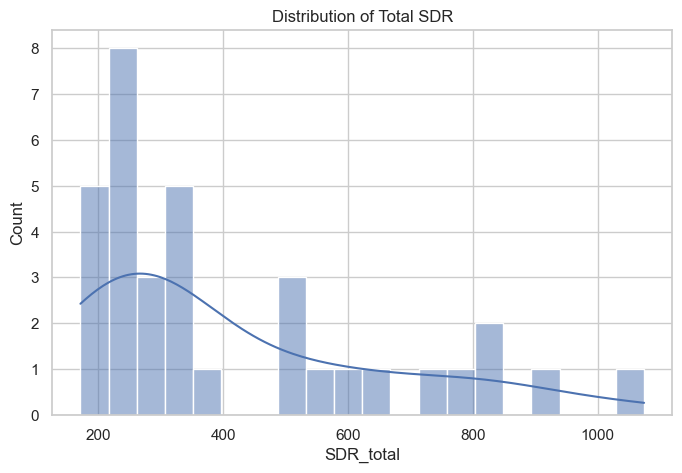

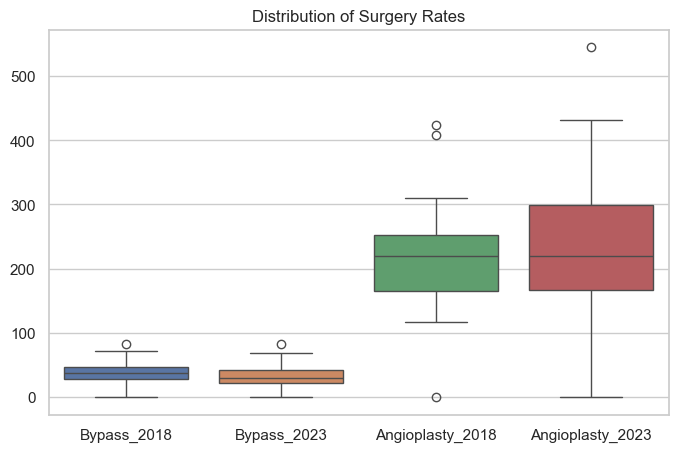

In [4]:
sns.set(style="whitegrid")

plt.figure(figsize=(8,5))
sns.histplot(df_deaths['SDR_total'], bins=20, kde=True)
plt.title("Distribution of Total SDR")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=df_surgery[['Bypass_2018','Bypass_2023','Angioplasty_2018','Angioplasty_2023']])
plt.title("Distribution of Surgery Rates")
plt.show()

These visuals show us: 

**1)** most European countries have SDRs (standard death rates; death rate per 100,000 population) below the value of 350.

**2)** There have been more angioplasty surgeries than bypass, in both years of 2018 and 2023. Bypass rates slightly decreased in 2023. Angioplasty rates had more variation between different countries in 2023, while the median did not seem to change between these two points of years. However, according to the data summary in above section, the mean value in 2023 increased (237.65 vs 216.58). This might mean, a few countries pulled up the average values by large increases.       

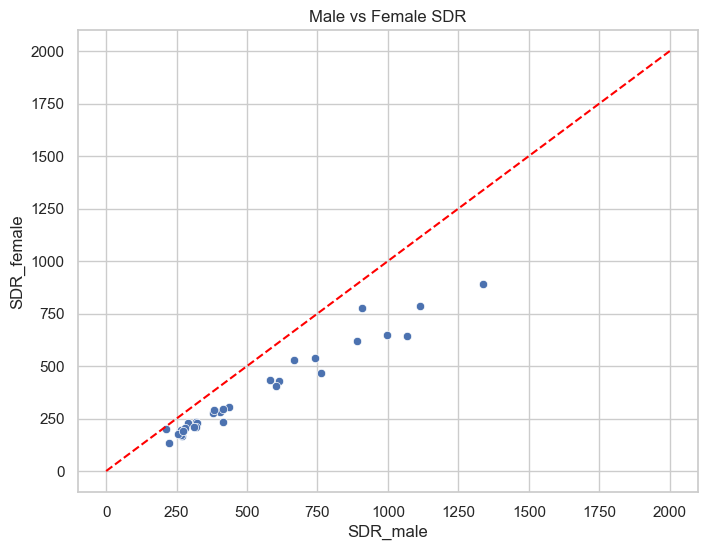

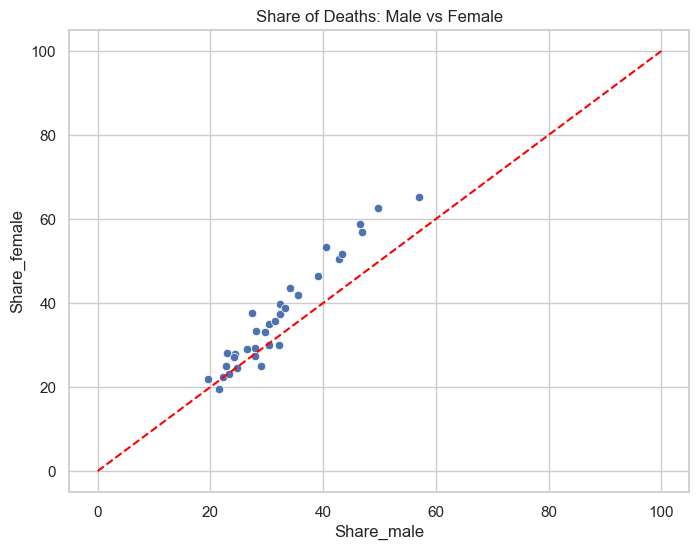

In [5]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='SDR_male', y='SDR_female', data=df_deaths)
plt.plot([0,2000],[0,2000], ls="--", color="red")
plt.title("Male vs Female SDR")
plt.show()

plt.figure(figsize=(8,6))
sns.scatterplot(x='Share_male', y='Share_female', data=df_deaths)
plt.plot([0,100],[0,100], ls="--", color="red")
plt.title("Share of Deaths: Male vs Female")
plt.show()

The first plot (top side) compares the risk of dying from CVD (per 100k). Men have higher CVD rates in every country of the dataset.

The second plot (bottom side) compares what fraction of all deaths for each gender are due to CVD. That fraction depends not only on CVD mortality but on the whole mortality profile of that gender.

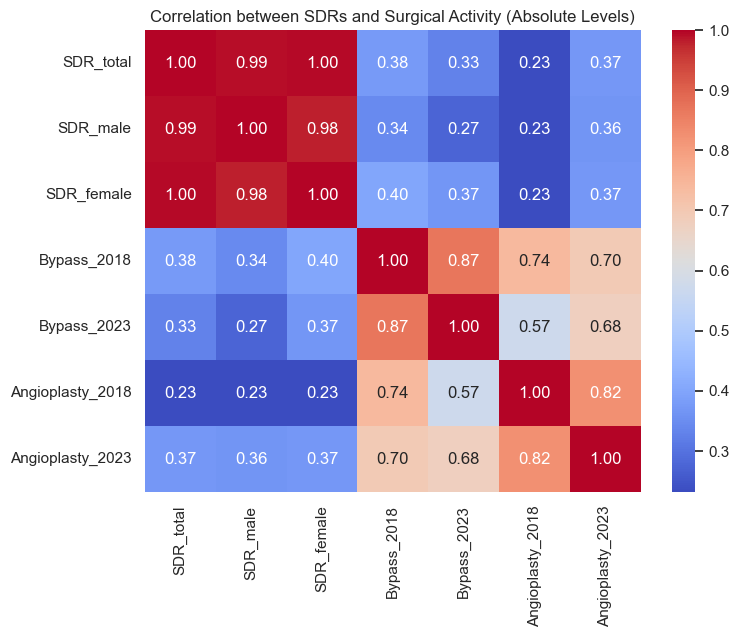

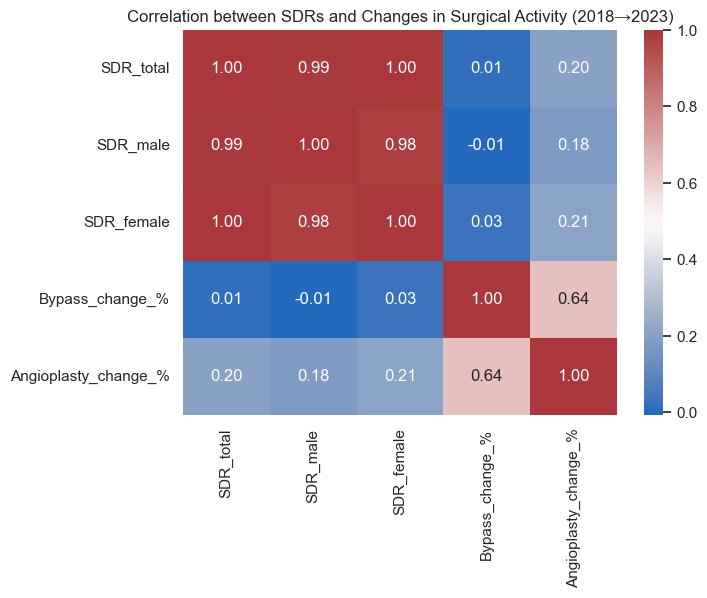

In [6]:
cols = [
    "SDR_total", "SDR_male", "SDR_female",
    "Bypass_2018", "Bypass_2023",
    "Angioplasty_2018", "Angioplasty_2023"
]

df_corr = df_deaths.merge(df_surgery, on="Country", how="inner")[cols]



corr_abs = df_corr.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_abs, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between SDRs and Surgical Activity (Absolute Levels)")
plt.show()



df_corr["Bypass_change_%"] = (
    (df_corr["Bypass_2023"] - df_corr["Bypass_2018"]) / df_corr["Bypass_2018"]
) * 100

df_corr["Angioplasty_change_%"] = (
    (df_corr["Angioplasty_2023"] - df_corr["Angioplasty_2018"]) / df_corr["Angioplasty_2018"]
) * 100



corr_change = df_corr[[
    "SDR_total", "SDR_male", "SDR_female",
    "Bypass_change_%", "Angioplasty_change_%"
]].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr_change, annot=True, cmap="vlag", fmt=".2f")
plt.title("Correlation between SDRs and Changes in Surgical Activity (2018→2023)")
plt.show()

The first heatmap (top side) shows positive but weak correlations (0.2–0.4) between SDRs and surgeries.
The potential reason for this might be a country might have high SDRs but low surgeries if access to interventions is limited, or low SDRs but high surgeries if it has intensive screening and treatment programs.
Another important note to mention here is the lag effect. Surgical rates (2018–2023) represent treatment, whereas SDRs reflect outcomes that evolve slower. Visible outcomes lag, so correlation weakens in short timeframes.In addition, the surgery types for specific years seem to be correlated, as well. For instance, in 2018, bypass and angioplasty rates had a correlation of 0.74. This correlation dropped to 0.68 in 2023.

The second heatmap (bottom side) shows whether reductions in SDR are linked to increases in surgery rates. A weak but positive correlation (around 0.2 for SDR vs Angioplasty) means countries that increased angioplasty rates also tended to see increases in SDR, unlike the expected. There was no simple linear relationship between increasing procedures and reducing deaths over this period. This may actually be resulted from the lag effect (explained above), similarly that the countries with high mortality may increase surgeries intensively, but the immediate SDR might not yet drop in that timeframe. This may be reflected from the small sample (limited number of countries) or short period of years (2018 → 2023). It may be important to note that, bypass and angioplasty rate change over these years had a positive correlation of 0.64 between each other. 

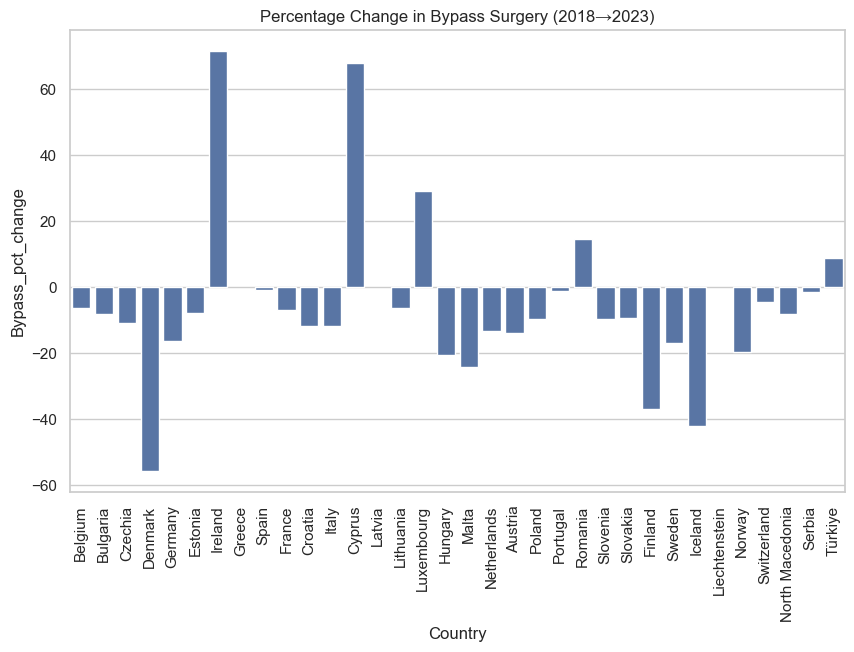

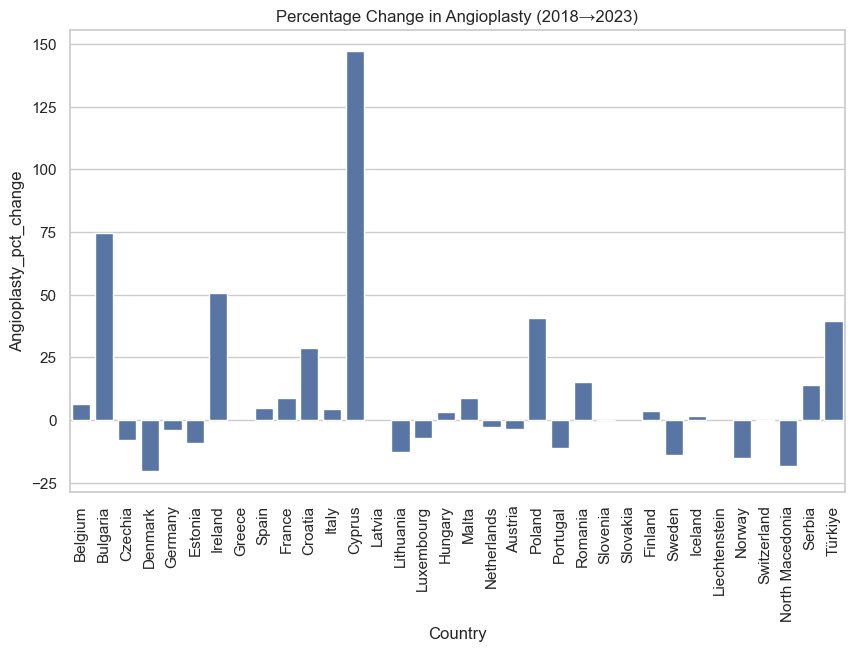

In [7]:
df_surgery['Bypass_change'] = df_surgery['Bypass_2023'] - df_surgery['Bypass_2018']
df_surgery['Bypass_pct_change'] = df_surgery['Bypass_change'] / df_surgery['Bypass_2018'] * 100
df_surgery['Angioplasty_change'] = df_surgery['Angioplasty_2023'] - df_surgery['Angioplasty_2018']
df_surgery['Angioplasty_pct_change'] = df_surgery['Angioplasty_change'] / df_surgery['Angioplasty_2018'] * 100

plt.figure(figsize=(10,6))
sns.barplot(x='Country', y='Bypass_pct_change', data=df_surgery)
plt.xticks(rotation=90)
plt.title("Percentage Change in Bypass Surgery (2018→2023)")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='Country', y='Angioplasty_pct_change', data=df_surgery)
plt.xticks(rotation=90)
plt.title("Percentage Change in Angioplasty (2018→2023)")
plt.show()

In these histograms, we can see the percentage changes of bypass and angioplasty surgeries across differernt European countries. 
According to these, Ireland has the most significant change in the bypass surgery percentage increase over 65%, closely followed by Cyprus, while their angioplasty rate changes were about 50% and nearly 150% increase, respectively. 
In majority of countries, bypass rate decreased excluding Ireland, Cyprus, Luxembourg, Romania and Türkiye. In majority of countries, angioplasty rates increased except Czechia, Denmark, Germany, Estonia, Lithuania, Luxembourg, Netehrlands, Austria, Portugal , Sweden, Norway and North Macedonia. 
Denmark showed the largest decrease in bypass rates by over 50%, followed by Iceland. 